<a href="https://colab.research.google.com/github/Utkarsh87/Capsule-Networks/blob/master/CapsuleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install keras==2.2.4

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [3]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

Using TensorFlow backend.


2.2.4
1.15.2


In [0]:
import numpy as np
import os
from keras import callbacks
from keras.utils.vis_utils import plot_model

import warnings 
warnings.filterwarnings('ignore')

# Layers in CapsNet

Define the key layers required to build any capsnet architecture

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transformation matrix/Weight matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate(tile) num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))

        # DYNAMIC ROUTING
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # update the raw weights for the next routing iteration
                # by adding the agreement to the previous raw weights
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

# Build the network

Build the required capsnet architecture using the layers defined above

In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Dynamic Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digit_caps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

# Margin Loss

Use custom margin loss as proposed in the original paper for gradient updates

In [0]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [48]:
num_classes = 10
routings = 3

# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=num_classes,
                num_routing=routings)
model.summary()

try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 1152, 8)      0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
lambda_5 (

# Load Data

In [49]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

(60000, 28, 28)


In [0]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
val_images = val_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.

train_labels = to_categorical(train_labels.astype('float32'))
test_labels = to_categorical(test_labels.astype('float32'))
val_labels = to_categorical(val_labels.astype('float32'))

In [51]:
print(train_images.shape)
print(type(train_images))
print(test_images.shape)
print(type(test_images))
print(val_images.shape)
print(type(val_images))

x_train = train_images
y_train = train_labels

x_val = val_images
y_val = val_labels

x_test = test_images
y_test = test_labels

(50000, 28, 28, 1)
<class 'numpy.ndarray'>
(10000, 28, 28, 1)
<class 'numpy.ndarray'>
(10000, 28, 28, 1)
<class 'numpy.ndarray'>


# Train the network

In [0]:
batch_size = 128
epochs = 10

In [0]:
def train(model, data, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_val, y_val) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})

    # Training without data augmentation:
    history = model.fit([x_train, y_train], [y_train, x_train], batch_size=batch_size, epochs=epochs,
              validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [54]:
train(model=model, data=((x_train, y_train), (x_val, y_val)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 128s 3ms/step - loss: 0.1014 - out_caps_loss: 0.1014 - out_recon_loss: 0.1470 - out_caps_acc: 0.9012 - val_loss: 0.0250 - val_out_caps_loss: 0.0250 - val_out_recon_loss: 0.0665 - val_out_caps_acc: 0.9822

Epoch 00001: val_loss improved from inf to 0.02503, saving model to weights-01.h5
Epoch 2/10
50000/50000 [==============================] - 126s 3ms/step - loss: 0.0202 - out_caps_loss: 0.0201 - out_recon_loss: 0.0662 - out_caps_acc: 0.9863 - val_loss: 0.0163 - val_out_caps_loss: 0.0163 - val_out_recon_loss: 0.0643 - val_out_caps_acc: 0.9879

Epoch 00002: val_loss improved from 0.02503 to 0.01628, saving model to weights-02.h5
Epoch 3/10
50000/50000 [==============================] - 127s 3ms/step - loss: 0.0135 - out_caps_loss: 0.0135 - out_recon_loss: 0.0637 - out_caps_acc: 0.9906 - val_loss: 0.0132 - val_out_caps_loss: 0.0132 - val_out_recon_loss: 0.0611 - val_out_caps_acc: 0

# Visualisation

In [0]:
# from IPython.display import Image
# Image('model.png', width=750, height=750)

In [60]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv('log.csv')
print(df.columns)

Index(['epoch', 'loss', 'lr', 'out_caps_acc', 'out_caps_loss',
       'out_recon_loss', 'val_loss', 'val_out_caps_acc', 'val_out_caps_loss',
       'val_out_recon_loss'],
      dtype='object')


Filter the values to visualise

In [0]:
# loss
loss = df['loss'].to_list()
val_loss = df['val_loss'].to_list()

# Break-down the losses into components
out_caps_loss = df['out_caps_loss'].to_list()
val_out_caps_loss = df['val_out_caps_loss'].to_list()

out_recon_loss = df['out_recon_loss'].to_list()
val_out_recon_loss = df['val_out_recon_loss'].to_list()

# accuracy
out_caps_acc = df['out_caps_acc'].to_list()
val_out_caps_acc = df['val_out_caps_acc'].to_list()

Configure plotting tool(here: matplotlib)

In [0]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
plt.style.use('fivethirtyeight')
plt.rc('grid', color='k', linestyle='--')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='gray', axisbelow=True, grid=True)

Plot the concerned values

Text(0.5, 1.0, 'Training and Validation Reconstruction Loss')

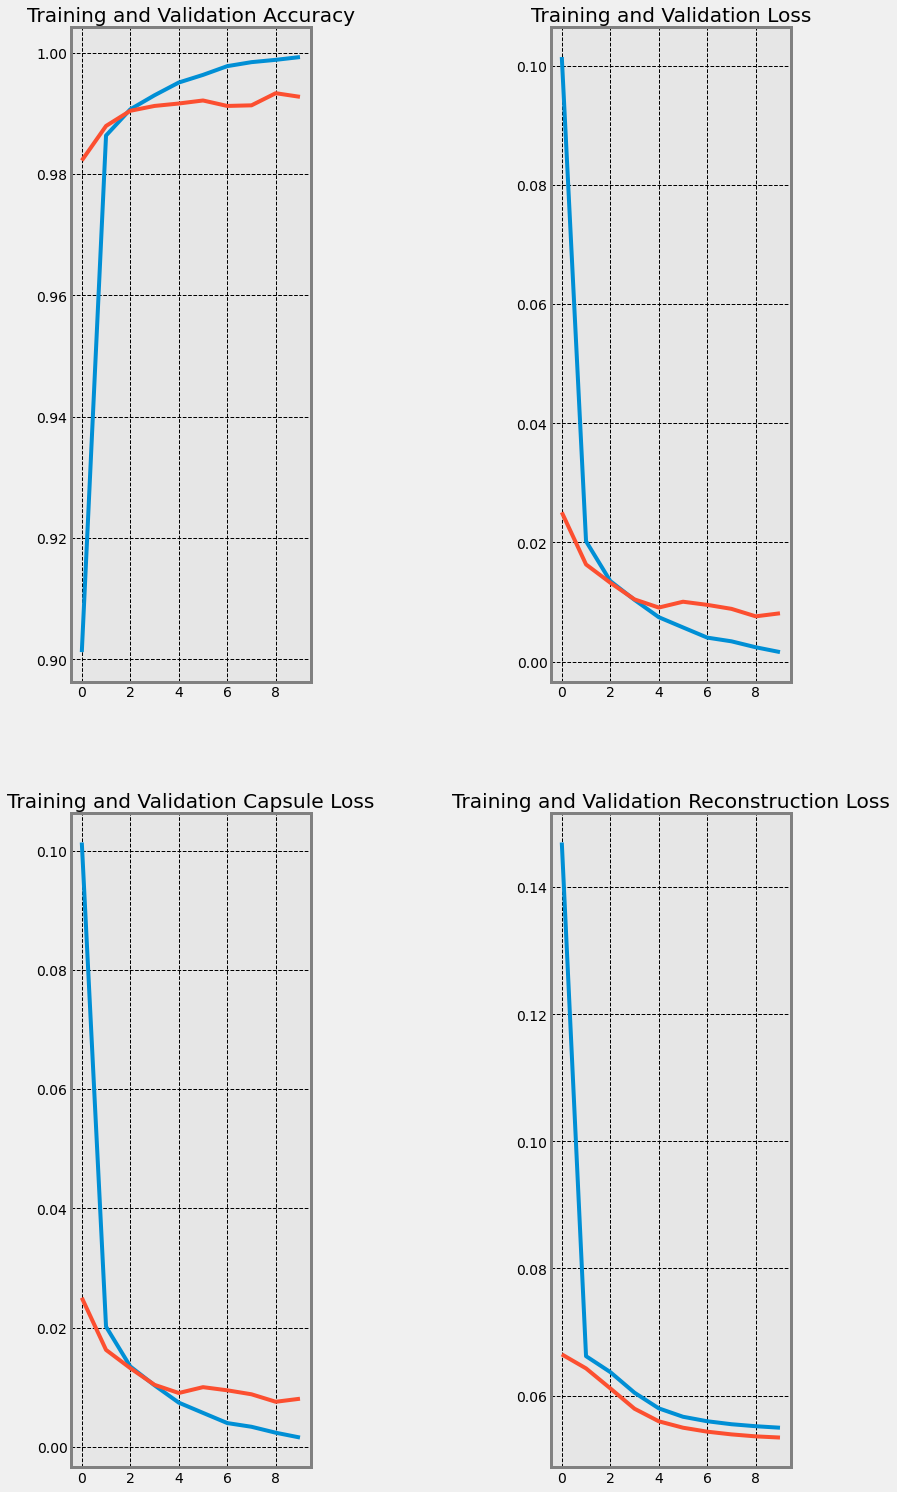

In [86]:
epochs = range(len(loss))

params = {'left' : 1,
          'right' : 3,
          'bottom' : 1,
          'top' : 3, 
          'wspace' : 1,                        
          'hspace' : 0.2}
              
plt.subplots_adjust(**params)

# Plot retrieved data : accuracy
plt.subplot(221)
plt.plot(epochs, out_caps_acc)
plt.plot(epochs, val_out_caps_acc)
plt.title("Training and Validation Accuracy")

# Plot retrieved data : loss
plt.subplot(222)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation Loss")

# Plot retrieved data : capsule loss
plt.subplot(223)
plt.plot(epochs, out_caps_loss)
plt.plot(epochs, val_out_caps_loss)
plt.title("Training and Validation Capsule Loss")

# Plot retrieved data : capsule loss
plt.subplot(224)
plt.plot(epochs, out_recon_loss)
plt.plot(epochs, val_out_recon_loss)
plt.title("Training and Validation Reconstruction Loss")